<a href="https://colab.research.google.com/github/lungnahahd/Tensorflow_Prac/blob/main/Batch_Norm_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from collections import OrderedDict


In [ ]:

def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [ ]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


In [ ]:
def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad


In [ ]:
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [ ]:

class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads


============== 1/16 ==============
epoch:0 | 0.117 - 0.129
epoch:1 | 0.097 - 0.117


<ipython-input-7-4bd93e01ab44>:96: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
<ipython-input-7-4bd93e01ab44>:96: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:2 | 0.097 - 0.137
epoch:3 | 0.097 - 0.159
epoch:4 | 0.097 - 0.166
epoch:5 | 0.097 - 0.19
epoch:6 | 0.097 - 0.21
epoch:7 | 0.097 - 0.228
epoch:8 | 0.097 - 0.245
epoch:9 | 0.097 - 0.256
epoch:10 | 0.097 - 0.274
epoch:11 | 0.097 - 0.289
epoch:12 | 0.097 - 0.302
epoch:13 | 0.097 - 0.32
epoch:14 | 0.097 - 0.332
epoch:15 | 0.097 - 0.345
epoch:16 | 0.097 - 0.354
epoch:17 | 0.097 - 0.368


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.386
epoch:19 | 0.097 - 0.402
============== 2/16 ==============
epoch:0 | 0.097 - 0.075


<ipython-input-7-4bd93e01ab44>:96: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-7-4bd93e01ab44>:96: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
<ipython-input-2-2119d56ae049>:30: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.125
epoch:2 | 0.097 - 0.17
epoch:3 | 0.097 - 0.187
epoch:4 | 0.097 - 0.213
epoch:5 | 0.097 - 0.241
epoch:6 | 0.097 - 0.266
epoch:7 | 0.097 - 0.303
epoch:8 | 0.097 - 0.321
epoch:9 | 0.097 - 0.343
epoch:10 | 0.097 - 0.351
epoch:11 | 0.097 - 0.373
epoch:12 | 0.097 - 0.402
epoch:13 | 0.097 - 0.419
epoch:14 | 0.097 - 0.435
epoch:15 | 0.097 - 0.453
epoch:16 | 0.097 - 0.468
epoch:17 | 0.097 - 0.487
epoch:18 | 0.097 - 0.493


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.509
============== 3/16 ==============
epoch:0 | 0.1 - 0.146
epoch:1 | 0.435 - 0.108
epoch:2 | 0.519 - 0.123
epoch:3 | 0.616 - 0.145
epoch:4 | 0.693 - 0.174
epoch:5 | 0.714 - 0.208
epoch:6 | 0.798 - 0.246
epoch:7 | 0.85 - 0.29
epoch:8 | 0.858 - 0.333
epoch:9 | 0.911 - 0.374
epoch:10 | 0.918 - 0.426
epoch:11 | 0.946 - 0.464
epoch:12 | 0.954 - 0.484
epoch:13 | 0.968 - 0.505
epoch:14 | 0.974 - 0.537
epoch:15 | 0.984 - 0.557
epoch:16 | 0.986 - 0.574
epoch:17 | 0.989 - 0.591
epoch:18 | 0.989 - 0.601


No handles with labels found to put in legend.


epoch:19 | 0.992 - 0.625
============== 4/16 ==============
epoch:0 | 0.092 - 0.088
epoch:1 | 0.303 - 0.077
epoch:2 | 0.454 - 0.157
epoch:3 | 0.551 - 0.243
epoch:4 | 0.619 - 0.318
epoch:5 | 0.658 - 0.374
epoch:6 | 0.7 - 0.45
epoch:7 | 0.732 - 0.503
epoch:8 | 0.759 - 0.547
epoch:9 | 0.766 - 0.582
epoch:10 | 0.779 - 0.621
epoch:11 | 0.82 - 0.654
epoch:12 | 0.827 - 0.682
epoch:13 | 0.83 - 0.698
epoch:14 | 0.857 - 0.711
epoch:15 | 0.864 - 0.728
epoch:16 | 0.872 - 0.745
epoch:17 | 0.877 - 0.77
epoch:18 | 0.875 - 0.781


No handles with labels found to put in legend.


epoch:19 | 0.891 - 0.794
============== 5/16 ==============
epoch:0 | 0.11 - 0.114
epoch:1 | 0.129 - 0.135
epoch:2 | 0.139 - 0.236
epoch:3 | 0.156 - 0.392
epoch:4 | 0.169 - 0.515
epoch:5 | 0.177 - 0.612
epoch:6 | 0.189 - 0.661
epoch:7 | 0.198 - 0.707
epoch:8 | 0.22 - 0.74
epoch:9 | 0.239 - 0.768
epoch:10 | 0.251 - 0.787
epoch:11 | 0.267 - 0.803
epoch:12 | 0.279 - 0.808
epoch:13 | 0.291 - 0.816
epoch:14 | 0.303 - 0.836
epoch:15 | 0.312 - 0.838
epoch:16 | 0.323 - 0.853
epoch:17 | 0.345 - 0.857
epoch:18 | 0.35 - 0.861


No handles with labels found to put in legend.


epoch:19 | 0.357 - 0.871
============== 6/16 ==============
epoch:0 | 0.111 - 0.103
epoch:1 | 0.116 - 0.159
epoch:2 | 0.116 - 0.412
epoch:3 | 0.116 - 0.592
epoch:4 | 0.116 - 0.678
epoch:5 | 0.116 - 0.736
epoch:6 | 0.116 - 0.779
epoch:7 | 0.116 - 0.816
epoch:8 | 0.127 - 0.851
epoch:9 | 0.175 - 0.866
epoch:10 | 0.157 - 0.871
epoch:11 | 0.116 - 0.881
epoch:12 | 0.116 - 0.891
epoch:13 | 0.116 - 0.907
epoch:14 | 0.116 - 0.909
epoch:15 | 0.116 - 0.917
epoch:16 | 0.116 - 0.925
epoch:17 | 0.122 - 0.932
epoch:18 | 0.196 - 0.942


No handles with labels found to put in legend.


epoch:19 | 0.193 - 0.95
============== 7/16 ==============
epoch:0 | 0.097 - 0.113
epoch:1 | 0.116 - 0.187
epoch:2 | 0.116 - 0.529
epoch:3 | 0.116 - 0.675
epoch:4 | 0.116 - 0.74
epoch:5 | 0.116 - 0.795
epoch:6 | 0.116 - 0.832
epoch:7 | 0.116 - 0.865
epoch:8 | 0.116 - 0.896
epoch:9 | 0.116 - 0.916
epoch:10 | 0.116 - 0.927
epoch:11 | 0.117 - 0.945
epoch:12 | 0.117 - 0.961
epoch:13 | 0.117 - 0.967
epoch:14 | 0.117 - 0.975
epoch:15 | 0.117 - 0.98
epoch:16 | 0.117 - 0.983
epoch:17 | 0.117 - 0.986
epoch:18 | 0.117 - 0.988


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.991
============== 8/16 ==============
epoch:0 | 0.116 - 0.114
epoch:1 | 0.117 - 0.425
epoch:2 | 0.117 - 0.713
epoch:3 | 0.117 - 0.783
epoch:4 | 0.117 - 0.813
epoch:5 | 0.116 - 0.859
epoch:6 | 0.116 - 0.89
epoch:7 | 0.116 - 0.924
epoch:8 | 0.116 - 0.949
epoch:9 | 0.116 - 0.966
epoch:10 | 0.116 - 0.975
epoch:11 | 0.116 - 0.985
epoch:12 | 0.116 - 0.992
epoch:13 | 0.116 - 0.992
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.997
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.116 - 0.12
epoch:1 | 0.116 - 0.557
epoch:2 | 0.116 - 0.728
epoch:3 | 0.117 - 0.795
epoch:4 | 0.116 - 0.871
epoch:5 | 0.116 - 0.909
epoch:6 | 0.116 - 0.937
epoch:7 | 0.116 - 0.952
epoch:8 | 0.116 - 0.861
epoch:9 | 0.116 - 0.983
epoch:10 | 0.116 - 0.988
epoch:11 | 0.116 - 0.991
epoch:12 | 0.116 - 0.997
epoch:13 | 0.116 - 0.998
epoch:14 | 0.116 - 0.998
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.998
============== 10/16 ==============
epoch:0 | 0.117 - 0.11
epoch:1 | 0.105 - 0.524
epoch:2 | 0.117 - 0.703
epoch:3 | 0.117 - 0.764
epoch:4 | 0.117 - 0.802
epoch:5 | 0.117 - 0.859
epoch:6 | 0.117 - 0.839
epoch:7 | 0.117 - 0.882
epoch:8 | 0.117 - 0.89
epoch:9 | 0.117 - 0.899
epoch:10 | 0.117 - 0.902
epoch:11 | 0.117 - 0.904
epoch:12 | 0.117 - 0.908
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.991
epoch:15 | 0.117 - 0.969
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.996
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.105 - 0.236
epoch:1 | 0.117 - 0.474
epoch:2 | 0.117 - 0.643
epoch:3 | 0.116 - 0.656
epoch:4 | 0.117 - 0.645
epoch:5 | 0.116 - 0.693
epoch:6 | 0.116 - 0.726
epoch:7 | 0.116 - 0.718
epoch:8 | 0.116 - 0.718
epoch:9 | 0.116 - 0.731
epoch:10 | 0.116 - 0.783
epoch:11 | 0.116 - 0.799
epoch:12 | 0.116 - 0.807
epoch:13 | 0.116 - 0.808
epoch:14 | 0.116 - 0.806
epoch:15 | 0.116 - 0.797
epoch:16 | 0.116 - 0.894
epoch:17 | 0.116 - 0.823
epoch:18 | 0.116 - 0.892


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.869
============== 12/16 ==============
epoch:0 | 0.116 - 0.117
epoch:1 | 0.117 - 0.322
epoch:2 | 0.117 - 0.622
epoch:3 | 0.117 - 0.674
epoch:4 | 0.117 - 0.72
epoch:5 | 0.117 - 0.754
epoch:6 | 0.117 - 0.749
epoch:7 | 0.116 - 0.737
epoch:8 | 0.117 - 0.768
epoch:9 | 0.116 - 0.791
epoch:10 | 0.117 - 0.599
epoch:11 | 0.117 - 0.802
epoch:12 | 0.117 - 0.796
epoch:13 | 0.117 - 0.811
epoch:14 | 0.117 - 0.813
epoch:15 | 0.117 - 0.813
epoch:16 | 0.117 - 0.813
epoch:17 | 0.117 - 0.813
epoch:18 | 0.117 - 0.889


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.896
============== 13/16 ==============
epoch:0 | 0.116 - 0.136
epoch:1 | 0.099 - 0.389
epoch:2 | 0.116 - 0.524
epoch:3 | 0.116 - 0.562
epoch:4 | 0.117 - 0.544
epoch:5 | 0.117 - 0.561
epoch:6 | 0.117 - 0.64
epoch:7 | 0.117 - 0.664
epoch:8 | 0.117 - 0.658
epoch:9 | 0.117 - 0.657
epoch:10 | 0.117 - 0.609
epoch:11 | 0.117 - 0.684
epoch:12 | 0.116 - 0.687
epoch:13 | 0.117 - 0.673
epoch:14 | 0.117 - 0.673
epoch:15 | 0.117 - 0.695
epoch:16 | 0.117 - 0.701
epoch:17 | 0.117 - 0.705
epoch:18 | 0.117 - 0.693


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.699
============== 14/16 ==============
epoch:0 | 0.105 - 0.14
epoch:1 | 0.116 - 0.418
epoch:2 | 0.116 - 0.515
epoch:3 | 0.116 - 0.531
epoch:4 | 0.116 - 0.512
epoch:5 | 0.116 - 0.595
epoch:6 | 0.116 - 0.598
epoch:7 | 0.116 - 0.598
epoch:8 | 0.116 - 0.6
epoch:9 | 0.117 - 0.606
epoch:10 | 0.116 - 0.604
epoch:11 | 0.116 - 0.614
epoch:12 | 0.116 - 0.616
epoch:13 | 0.116 - 0.617
epoch:14 | 0.116 - 0.615
epoch:15 | 0.116 - 0.643
epoch:16 | 0.117 - 0.665
epoch:17 | 0.117 - 0.625
epoch:18 | 0.117 - 0.706


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.708
============== 15/16 ==============
epoch:0 | 0.1 - 0.177
epoch:1 | 0.116 - 0.301
epoch:2 | 0.117 - 0.308
epoch:3 | 0.117 - 0.328
epoch:4 | 0.117 - 0.397
epoch:5 | 0.117 - 0.372
epoch:6 | 0.117 - 0.409
epoch:7 | 0.117 - 0.406
epoch:8 | 0.116 - 0.408
epoch:9 | 0.116 - 0.411
epoch:10 | 0.117 - 0.414
epoch:11 | 0.116 - 0.419
epoch:12 | 0.116 - 0.429
epoch:13 | 0.116 - 0.43
epoch:14 | 0.116 - 0.422
epoch:15 | 0.116 - 0.431
epoch:16 | 0.116 - 0.431
epoch:17 | 0.116 - 0.419
epoch:18 | 0.116 - 0.425


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.425
============== 16/16 ==============
epoch:0 | 0.117 - 0.205
epoch:1 | 0.117 - 0.206
epoch:2 | 0.117 - 0.309
epoch:3 | 0.116 - 0.312
epoch:4 | 0.116 - 0.318
epoch:5 | 0.116 - 0.305
epoch:6 | 0.116 - 0.327
epoch:7 | 0.116 - 0.322
epoch:8 | 0.117 - 0.319
epoch:9 | 0.117 - 0.322
epoch:10 | 0.116 - 0.324
epoch:11 | 0.117 - 0.327
epoch:12 | 0.116 - 0.327
epoch:13 | 0.116 - 0.426
epoch:14 | 0.116 - 0.422
epoch:15 | 0.116 - 0.424
epoch:16 | 0.116 - 0.432
epoch:17 | 0.116 - 0.43
epoch:18 | 0.116 - 0.429
epoch:19 | 0.116 - 0.432


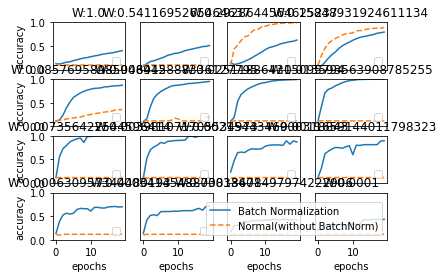

In [ ]:


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()
